In [1]:
!pip install d2l

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from d2l import tensorflow as d2l
import numpy as np
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
batch_siz=512
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = d2l.download_extract('pokemon')
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,labels=None, batch_size=batch_siz, image_size=(64, 64),shuffle=True)
print(batch_siz)

Found 40597 files belonging to 1 classes.
512


In [5]:
def pre_pross(image):
    return (image*2/255)-1
pre_pross_pokemon=pokemon.map(lambda x: pre_pross(x) )

In [6]:
train_data=pre_pross_pokemon

In [7]:
def de_process(image):
    return (image+1)*255/2
def post_pross(image):
  idx=np.where(image>255)
  image[idx]=255
  idx=np.where(image<0)
  image[idx]=0
  return image

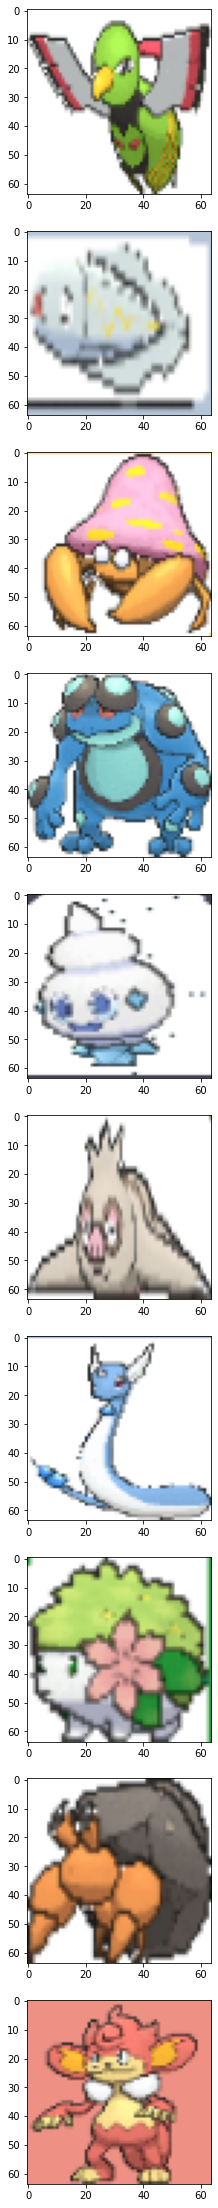

In [8]:
n=50
fig,ax=plt.subplots(10,1,figsize=(20,40))
temp=list(pokemon.take(1))[0]
for k in range(10):
    ax[k].imshow(temp[k].numpy().astype('uint8'))

In [9]:
#generator
##shape of latent space:
def get_gen(latent=128):
    gen_input=keras.Input(shape=(latent,))
    x=keras.layers.Dense(8*8*latent)(gen_input)
    x=keras.layers.Reshape((8,8,latent))(x)
    x=keras.layers.Conv2DTranspose(latent,kernel_size=4,strides=2,padding='same')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.Conv2DTranspose(latent*2,kernel_size=4,strides=2,padding='same')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU()(x)
    gen_output=keras.layers.Conv2DTranspose(3,kernel_size=4,strides=2,padding='same',activation='tanh')(x)
    return keras.Model(inputs=gen_input,outputs=gen_output)

In [10]:
def get_discri(latent=128):
    dis_input=keras.Input(shape=(64,64,3))
    x=keras.layers.Conv2D(2*latent,kernel_size=4,strides=2)(dis_input)
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.Conv2D(latent,kernel_size=4,strides=2)(x)
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.Flatten()(x)
    x=keras.layers.Dropout(0.2)(x)
    dis_output=keras.layers.Dense(1,activation='sigmoid')(x)
    return keras.Model(inputs=dis_input,outputs=dis_output)

In [11]:
class ungthuGAN(keras.Model):
    def __init__(self,gen,discri,latent):
        super(ungthuGAN,self).__init__()
        self.discri=discri
        self.gen=gen
        self.latent=latent
    def compile(self,gen_optimizer,discri_optimizer,gen_loss,discri_loss):
        super(ungthuGAN,self).compile()
        self.gen_optimizer=gen_optimizer
        self.discri_optimizer=discri_optimizer
        self.gen_loss=gen_loss
        self.discri_loss=discri_loss
        self.discri_loss_metric = keras.metrics.Mean(name="discri_loss")
        self.gen_loss_metric = keras.metrics.Mean(name="gen_loss")
    @property
    def metrics(self):
        #tao metric de giam sat loss
        return [self.gen_loss_metric,self.discri_loss_metric]

    def train_step(self,real_input):
        batch_size=tf.shape(real_input)[0]
        ## huan luyen discriminator-----
        #lay du lieu tu phan phoi chuan dua vao dau vao cua gen:
        gen_in=tf.random.normal(shape=(batch_size,self.latent))
        #chuyen du lieu ngau nhien qua gen de cho ra dau ra:
        gen_out=self.gen(gen_in)
        #xep chong anh that va anh gia len nhau:
        discri_in=tf.concat([gen_out,real_input],axis=0)
        discri_labels=tf.concat([tf.ones(shape=(batch_size,1)),tf.zeros(shape=(batch_size,1))],axis=0)
        #cap nhat trong so discriminator:
        with tf.GradientTape() as tape:
            discri_out=self.discri(discri_in)
            discri_loss=self.discri_loss(discri_labels,discri_out)
        grads=tape.gradient(discri_loss,self.discri.trainable_weights)
        self.discri_optimizer.apply_gradients(zip(grads,self.discri.trainable_weights))
        ## huan luyen generator-----
        #lay du lieu tu phan phoi chuan dua vao dau vao cua gen:
        gen_in=tf.random.normal(shape=(batch_size,self.latent))
        #chuyen du lieu ngau nhien qua gen de cho ra dau ra:
        discri_labels=tf.zeros(shape=(batch_size,1))
        with tf.GradientTape() as tape:
            discri_out=self.discri(self.gen(gen_in))
            gen_loss=2*self.gen_loss(discri_labels,discri_out)
        grads=tape.gradient(gen_loss,self.gen.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(grads,self.gen.trainable_weights))
        ## cap nhat metric
        self.gen_loss_metric.update_state(gen_loss)
        self.discri_loss_metric.update_state(discri_loss)
        return {
            "gen_loss": self.gen_loss_metric.result(),
            "discri_loss": self.discri_loss_metric.result(),
        }

In [12]:
generator=get_gen()
discriminator=get_discri()
my_gan=ungthuGAN(generator,discriminator,latent=128)
generator.summary()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0     

In [ ]:
my_gan.compile(gen_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.5),
               discri_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.5),
               gen_loss=keras.losses.BinaryCrossentropy(),
               discri_loss=keras.losses.BinaryCrossentropy())
my_gan.fit(train_data,epochs=50)

Epoch 1/50
159/159 [==============================] - 132s 744ms/step - gen_loss: 5.0724 - discri_loss: 0.4531
Epoch 2/50
159/159 [==============================] - 119s 746ms/step - gen_loss: 4.5773 - discri_loss: 0.5759
Epoch 3/50
159/159 [==============================] - 120s 748ms/step - gen_loss: 3.7891 - discri_loss: 0.5957
Epoch 4/50
159/159 [==============================] - 119s 745ms/step - gen_loss: 3.4112 - discri_loss: 0.6075
Epoch 5/50
159/159 [==============================] - 119s 747ms/step - gen_loss: 3.1976 - discri_loss: 0.5995
Epoch 6/50
159/159 [==============================] - 119s 746ms/step - gen_loss: 3.6920 - discri_loss: 0.5837
Epoch 7/50
159/159 [==============================] - 119s 744ms/step - gen_loss: 3.8211 - discri_loss: 0.5523
Epoch 8/50
159/159 [==============================] - 119s 746ms/step - gen_loss: 4.0362 - discri_loss: 0.6449
Epoch 9/50
159/159 [==============================] - 119s 745ms/step - gen_loss: 3.3151 - discri_loss: 0.5803
E

In [34]:
my_gan=ungthuGAN(generator,discriminator,latent=128)
my_gan.compile(gen_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
               discri_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5),
               gen_loss=keras.losses.BinaryCrossentropy(),
               discri_loss=keras.losses.BinaryCrossentropy())
my_gan.fit(train_data,epochs=20)

Epoch 1/20
80/80 [==============================] - 122s 1s/step - gen_loss: 3.1864 - discri_loss: 0.3169
Epoch 2/20
80/80 [==============================] - 118s 1s/step - gen_loss: 3.2666 - discri_loss: 0.2909
Epoch 3/20
80/80 [==============================] - 118s 1s/step - gen_loss: 3.3205 - discri_loss: 0.2921
Epoch 4/20
80/80 [==============================] - 118s 1s/step - gen_loss: 3.3467 - discri_loss: 0.2910
Epoch 5/20
80/80 [==============================] - 119s 1s/step - gen_loss: 3.4123 - discri_loss: 0.2926
Epoch 6/20
80/80 [==============================] - 118s 1s/step - gen_loss: 3.4290 - discri_loss: 0.2938
Epoch 7/20
80/80 [==============================] - 119s 1s/step - gen_loss: 3.4349 - discri_loss: 0.2945
Epoch 8/20
80/80 [==============================] - 118s 1s/step - gen_loss: 3.4205 - discri_loss: 0.2901
Epoch 9/20
80/80 [==============================] - 118s 1s/step - gen_loss: 3.4472 - discri_loss: 0.2926
Epoch 10/20
80/80 [===========================

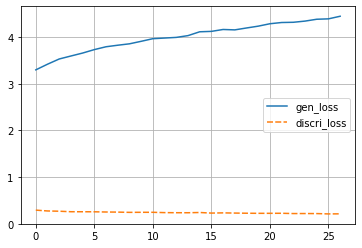

In [ ]:
fig,ax=plt.subplots(1,1)
sns.lineplot(data=my_gan.history.history,ax=ax)
ax.grid()

In [184]:
#generator.save('//content//drive//MyDrive//Colab Notebooks//GAN//Generator',include_optimizer=True,
#    save_format=None,
#    signatures=None,
#    options=None,
#    save_traces=True,)
#discriminator.save('//content//drive//MyDrive//Colab Notebooks//GAN//Discriminator',include_optimizer=True,
#    save_format=None,
#    signatures=None,
#    options=None,
#    save_traces=True,)

INFO:tensorflow:Assets written to: //content//drive//MyDrive//Colab Notebooks//GAN//Generator/assets
INFO:tensorflow:Assets written to: //content//drive//MyDrive//Colab Notebooks//GAN//Discriminator/assets


In [33]:
generator=tf.keras.models.load_model(
    '//content//drive//MyDrive//Colab Notebooks//GAN//Generator', custom_objects=None, compile=True, options=None
)
discriminator=tf.keras.models.load_model(
    '//content//drive//MyDrive//Colab Notebooks//GAN//Discriminator', custom_objects=None, compile=True, options=None
)

In [35]:
fig,ax=plt.subplots(10,10,figsize=(30,40))
for i in range(10):
  for j in range(10):
      rand=tf.random.normal(shape=(1,128))
      out=generator(rand)
      ax[i,j].imshow(post_pross(de_process(out.numpy()[0])).astype('uint8'))
      ax[i,j].set_title('score: '+str(discriminator(out).numpy()[0][0]))

Output hidden; open in https://colab.research.google.com to view.

In [186]:
n=50
fig,ax=plt.subplots(10,10,figsize=(30,40))
temp=list(pokemon.take(1))[0]
for k in range(10):
  for u in range(10):
    ax[k,u].imshow(temp[10*k+u].numpy().astype('uint8'))

Output hidden; open in https://colab.research.google.com to view.

(array([747]), array([0]))


Text(0.5, 1.0, '0.16630699')

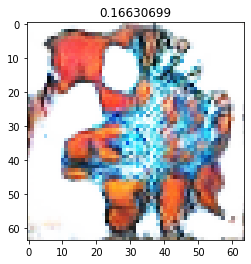

In [185]:
rand=tf.random.normal(shape=(2000,128))
out=generator(rand)
score=discriminator(out)
idx=np.where(score==min(score))
print(np.where(score==min(score)))
fig,ax=plt.subplots()
ax.imshow(de_process(out[idx[0][0]].numpy()).astype('uint8'))
ax.set_title(str(min(score).numpy()[0]))

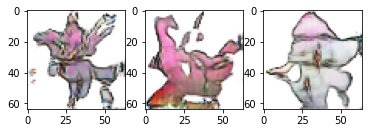

In [238]:
rand1=tf.random.normal(shape=(1,128))
rand2=tf.random.normal(shape=(1,128))
rand3=tf.random.normal(shape=(1,128))
step=6
fig,ax=plt.subplots(1,3)
ax[0].imshow(de_process(generator(rand1)[0]).numpy().astype('uint8'))
ax[1].imshow(de_process(generator(rand2)[0]).numpy().astype('uint8'))
ax[2].imshow(de_process(generator(rand3)[0]).numpy().astype('uint8'))

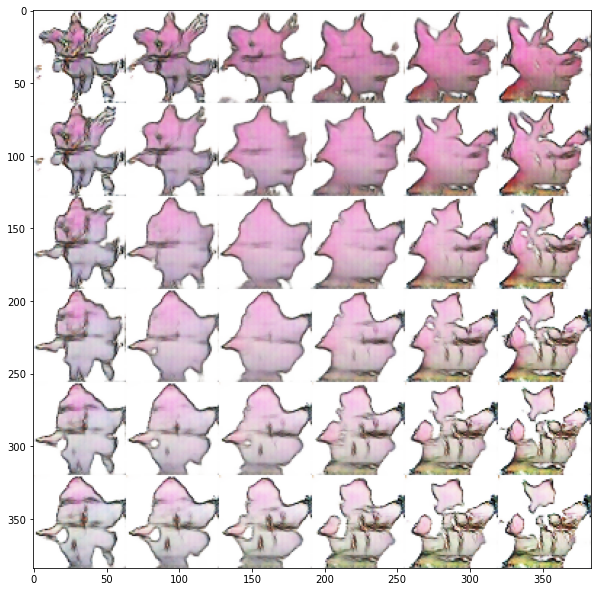

In [239]:
len_step_h=(-rand1+rand2)/step
len_step_v=(-rand1+rand3)/step
vector_h=np.ones(shape=(step,step,1))*rand1+np.arange(0,step,1).reshape(-1,1)*len_step_h*np.ones(shape=(step,step,1))
u=tf.transpose(tf.reshape(np.arange(0,step,1).reshape(-1,1)*len_step_v,(1,step,128))*np.ones(shape=(step,step,1)),perm=[1,0,2])
vector_h=vector_h+u
im_out=[]
for vec in vector_h:
  out=de_process(generator(vec)).numpy().astype('uint8')
  im_out.append(tf.concat([out[i] for i in range(step)],axis=1))
im_out=tf.concat(im_out,axis=0)
ax,fig=plt.subplots(figsize=(10,20))
plt.imshow(im_out)